In [1]:
import pandas as pd
import requests

import fastf1 as ff1
from fastf1 import plotting

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def ergast_retrieve(api_endpoint: str):
    url = f'https://ergast.com/api/f1/{api_endpoint}.json'
    response = requests.get(url).json()
    
    return response['MRData']

In [3]:
year = 2023
drivers_to_exclude = []

In [4]:
all_quali_results = pd.DataFrame()

team_drivers = {}

current_round = 1

while True:
    race = ergast_retrieve(f'{year}/{current_round}/qualifying')
    
    if not race['RaceTable']['Races']:
        break

    results = race['RaceTable']['Races'][0]['QualifyingResults']

    quali_results = {'round': current_round}

    for j in range(len(results)):
        driver = results[j]['Driver']['code']
        position = int(results[j]['position'])
        team = results[j]['Constructor']['name']
        
        if driver in drivers_to_exclude:
            continue
        
        if not team in team_drivers:
            team_drivers[team] = [driver]
        else:
            if not driver in team_drivers[team]:
                team_drivers[team].append(driver)
                
        quali_results[driver] = position
        
    quali_results = pd.DataFrame([quali_results])
            
    all_quali_results = pd.concat([all_quali_results, quali_results], ignore_index=True)
    
    current_round += 1

In [5]:
all_quali_battle_results = []
team_colors_palette = []

for team in team_drivers:
    drivers = team_drivers[team]
    
    quali_results = all_quali_results[drivers]
    
    fastest_driver_per_round = quali_results.dropna().idxmin(axis=1)
    
    quali_battle_result = fastest_driver_per_round.value_counts().reset_index()
    
    for _, driver in quali_battle_result.iterrows():
        all_quali_battle_results.append({
            'driver': driver['index'],
            'team': team,
            'quali_score': driver[0]
        })
    
    team_colors_palette.append(ff1.plotting.team_color(team))
    team_colors_palette = ['#D3D3D3' if v is None else v for v in team_colors_palette]


all_quali_battle_results = pd.DataFrame.from_dict(all_quali_battle_results)

C:\Users\larsl\AppData\Local\Temp\ipykernel_16544\3848268827.py:9: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  fastest_driver_per_round = quali_results.dropna().idxmin(axis=1)


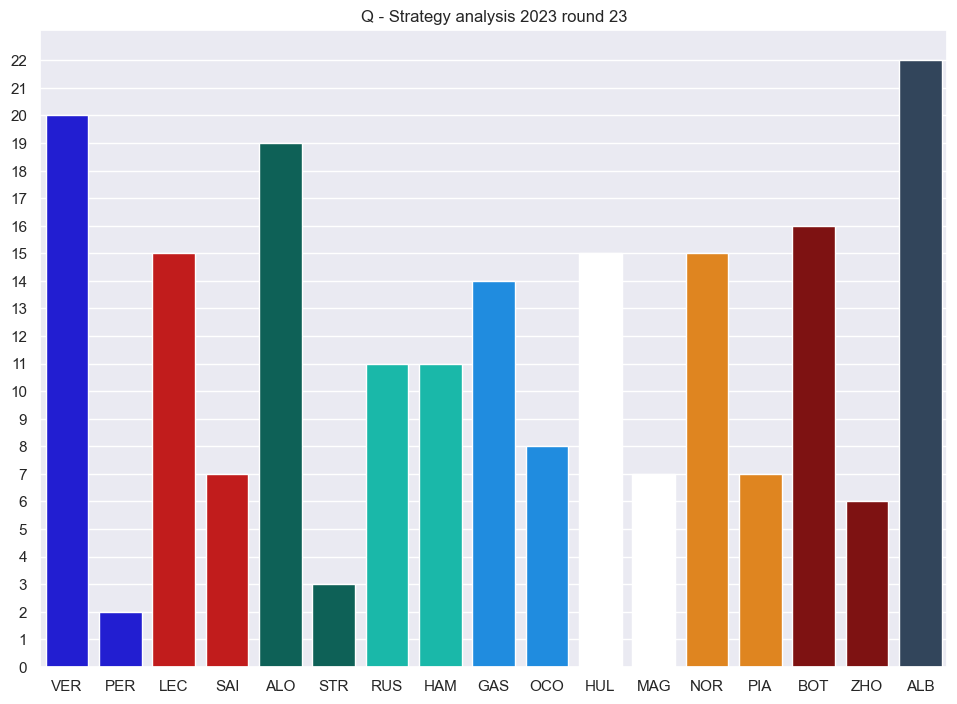

In [6]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

custom_palette = sns.set_palette(sns.color_palette(team_colors_palette))

fig, ax = plt.subplots()

title = f'Q - Strategy analysis {str(year)} round {str(current_round)}'

ax.set_title(title)

g = sns.barplot(
    x='driver',
    y='quali_score', 
    hue='team',
    data=all_quali_battle_results, 
    dodge=False,
    palette=custom_palette,
)

plt.yticks(range(max(all_quali_battle_results['quali_score']) + 1))

plt.legend([],[], frameon=False)

g.set(xlabel=None)
g.set(ylabel=None)

plt.savefig(f'Figures/{title}')

plt.show()